# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

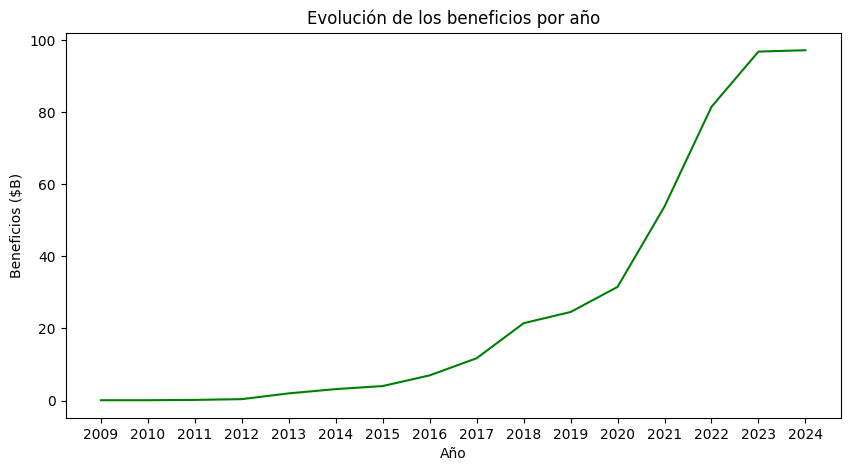

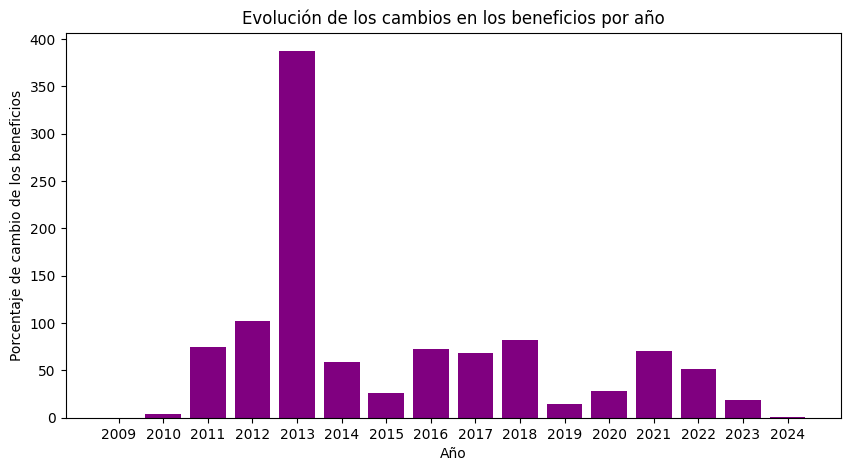

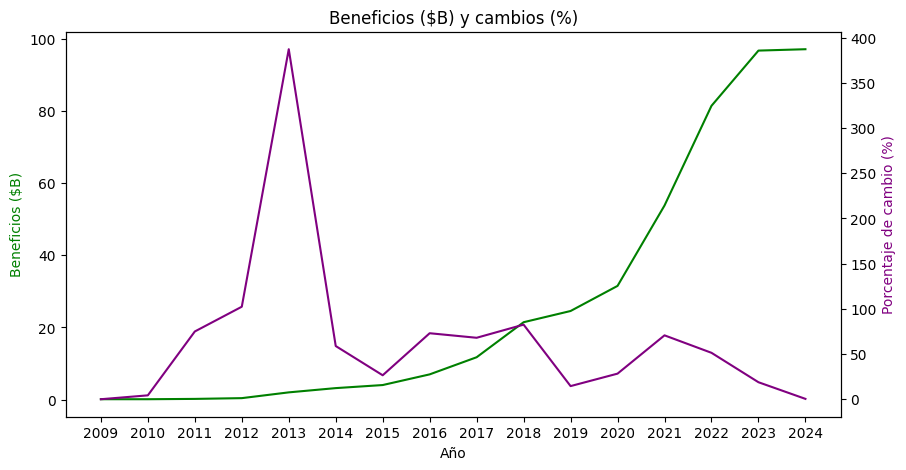

In [14]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

url="https://companies-market-cap-copy.vercel.app/index.html"

response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    print(f"Error al obtener la página: {response.status_code}")

tables= soup.find("table")

tables 

trows = tables.find_all("tr")
headers = [header.text.strip() for header in trows[0].find_all("th")]

data = []

for row in trows[1:]:
    cols = row.find_all("td")
    data.append([col.text.strip() for col in cols])

df = pd.DataFrame(data, columns=headers)

def process_revenue(column):
    if "B" in column or '$' in column:
        column = float(column.replace("B", "").replace("$", ""))
        return column
    
def process_change(column):
    if "%" in column:
        column = float(column.replace("%", ""))
    if column=="":
        column=0
    
    return column


df["Revenue"] = df["Revenue"].apply(process_revenue)

df["Change"] = df["Change"].apply(process_change)

df.sort_values("Year", inplace=True)


db_name = "tesla.db"

conn = sqlite3.connect(db_name)
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS tesla_data (
        Year INTEGER,
        Revenue REAL,
        Change REAL
    )
''')

df.to_sql("tesla_data", conn, if_exists="replace", index=False)


conn.commit()
conn.close()


plt.figure(figsize=(10, 5))
plt.plot(df["Year"], df["Revenue"], color="Green")
plt.xlabel("Año")
plt.ylabel("Beneficios ($B)")
plt.title("Evolución de los beneficios por año")
plt.savefig("Evolución de los beneficios por año")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(df["Year"], df["Change"], color='purple')
plt.xlabel("Año")
plt.ylabel("Porcentaje de cambio de los beneficios")
plt.title("Evolución de los cambios en los beneficios por año")
plt.savefig("Evolución de los cambios en los beneficios por año")
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlabel("Año")
ax.set_ylabel("Beneficios ($B)", color='green')
ax.plot(df["Year"], df["Revenue"], color='green', label="Beneficios ($B)")

ax2 = ax.twinx()
ax2.set_ylabel("Porcentaje de cambio (%)", color='purple')
ax2.plot(df["Year"], df["Change"], color='purple', label="Porcentaje de cambio (%)")

plt.title("Beneficios ($B) y cambios (%)")
plt.savefig("Beneficios vs cambio")
plt.show()
